# Examples to analyze area lipid and thickness from the NMRlipids databank

This notebook exemplifies how to:
1. Plot correlation between membrane thickness and area
2. Plot correlations between form factor minima, area per lipid, membrane thickness and order parameters
3. Plot area per lipid from binary mixtures as function of lipid composition

# Initialize NMRlipids databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml
from scipy.interpolate import interpn
import pandas as pd
import seaborn as sn
from scipy import stats

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Databank/Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid/(2*APL)

def CalcAreaPerMolecule(system):
    APLpath = system['path'] + 'apl.json'
    try:
        f = open(APLpath)
        APLdata = json.load(f)
        sumAPL = 0
        sumIND = 0
        for i,j in APLdata.items():
            sumAPL += j
            sumIND += 1
        APL = sumAPL/sumIND
        return(APL)
    except:
        print('apl.json not found from' + system['path'])
        
def GetThickness(system):
    ThicknessPath = system['path'] + 'thickness.json'
    try:
        f = open(ThicknessPath)
        thickness = json.load(f)
        return(thickness)
    except:
        return 0
        #print('thickness.json not found from' + system['path'])

def GetNlipids(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid

        
def getWaterPermeation(system):
    filename = system['path'].replace('../../Databank/Data/Simulations/','../../DataBankManuscript/Data/MD-PERMEATION/')
    filename = filename + 'Counting_events.txt'
    try:
        with open(filename) as f:
            last_line = f.readlines()[-1]
        events = float(last_line.split()[1])
        time = float(last_line.split()[0])
        
        APL = CalcAreaPerMolecule(system)
        Nlipids = GetNlipids(system)
        
        #print(events, APL, Nlipids)
        #print(events/(time*10**(-3)*APL*0.01*Nlipids*0.5))
        
        # Number of events per time and area (1/(micros*nm^2))
        return events/(time*10**(-3)*APL*0.01*Nlipids*0.5)
        
    except:
        pass

    
    
def GetFormFactorMin(system):
    FormFactorPath = system['path'] + 'FormFactor.json'
    #try:
    f = open(FormFactorPath)
    FormFactor = json.load(f)
    min = 1000
    iprev = FormFactor[0][1]
    iprevD = 0
    minX = []
    for i in FormFactor:
        iD = i[1]-iprev
        if iD > 0 and iprevD < 0 and i[0] > 0.1:
            minX.append(i[0])
        iprevD = i[1]-iprev
        iprev = i[1]
        
    return(minX)

def plotAPLS(MATRIX,ADDITIVE):
    ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".dat"):
                df=pd.read_csv(filepath, sep = " ", header =  None, names=["fraction", "area", "DOI"])
                df2 = df.groupby('fraction')['area'].mean().apply(lambda x: '{:.2f}'.format(x))
                df2.to_csv(filepath, sep = " ", header =  None)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    x = [float(line.split()[0]) for line in lines]
                    y = [float(line.split()[1]) for line in lines]
                    #print(filepath,x,y)
                    if len(set(x)) > 1:
                        plt.plot(x,y,label = filename,marker='o',linewidth=2, markersize=12)
    plt.legend(bbox_to_anchor=(1.05, 1),loc='best',fontsize=10)
    #plt.legend(loc='best', fontsize=10)
    plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX, fontsize=15)
    plt.ylabel('Area per molecule (Å)^2', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(ResultDir + 'APL.pdf')
    plt.show()

def plotThickness(MATRIX,ADDITIVE):
    ResultDir = './resultsThickness/' + ADDITIVE + '_in_' + MATRIX + '/'
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".dat"):
                df=pd.read_csv(filepath, sep = " ", header =  None, names=["fraction", "area", "DOI"])
                df2 = df.groupby('fraction')['area'].mean().apply(lambda x: '{:.2f}'.format(x))
                df2.to_csv(filepath, sep = " ", header =  None)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    x = [float(line.split()[0]) for line in lines]
                    y = [float(line.split()[1]) for line in lines]
                    #print(filepath,x,y)
                    if len(set(x)) > 1:
                        plt.plot(x,y,label = filename,marker='o')
    plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
    plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
    plt.ylabel('Thickness (nm)')
    plt.show()

def plotWaterPermeation(MATRIX,ADDITIVE):
    ResultDir = './resultsWaterPermeation/' + ADDITIVE + '_in_' + MATRIX + '/'
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".dat"):
                df=pd.read_csv(filepath, sep = " ", header =  None, names=["fraction", "area", "DOI"])
                df2 = df.groupby('fraction')['area'].mean().apply(lambda x: '{:.2f}'.format(x))
                df2.to_csv(filepath, sep = " ", header =  None)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    x = [float(line.split()[0]) for line in lines]
                    y = [float(line.split()[1]) for line in lines]
                    #print(filepath,x,y)
                    if len(set(x)) > 1:
                        plt.plot(x,y,label = filename,marker='o')
    plt.legend(bbox_to_anchor=(1.5, 1),loc='upper right')
    plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
    plt.ylabel('Water permeation [events/(micros*nm^2)]')
    plt.show()

    
    
def interpolateAPL(LIPID1,LIPID2,LIPID3,FFfile,prop):
    values = {}
    
    ResultDir = './results' + prop + '/' + LIPID2 + '_in_' + LIPID1 + '/'
    #print(ResultDir)
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:                
            filepath = subdir + os.sep + filename
            #print(filename)
            if filename == FFfile:
                print(filepath)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    for line in lines:
                        LIPID2comp = float(line.split()[0])
                        LIPID1comp = 100-float(line.split()[0])
                        LIPID3comp = 0
                        apl = float(line.split()[1])
                        #print(filepath)
                        #if len(LIPID1comp) > 1:
                        #points = (LIPID1comp,LIPID2comp,LIPID3comp)
                        values[LIPID1comp,LIPID2comp,LIPID3comp] = apl
    
    
    ResultDir = './results' + prop + '/' + LIPID3 + '_in_' + LIPID2 + '/'
    #print(ResultDir)
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:                
            filepath = subdir + os.sep + filename
            #print(filename)
            if filename == FFfile:
                print(filepath)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    for line in lines:
                        LIPID3comp = float(line.split()[0])
                        LIPID2comp = 100-float(line.split()[0])
                        LIPID1comp = 0
                        apl = float(line.split()[1])
                        #print(filepath)
                        #if len(LIPID1comp) > 1:
                        #points = (LIPID1comp,LIPID2comp,LIPID3comp)
                        values[LIPID1comp,LIPID2comp,LIPID3comp] = apl

                        
    ResultDir = './results' + prop + '/' + LIPID3 + '_in_' + LIPID1 + '/'
    #print(ResultDir)
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            #print(filename)
            if filename == FFfile:
                print(filepath)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    for line in lines:
                        LIPID1comp = float(line.split()[0])
                        LIPID3comp = 100-float(line.split()[0])
                        LIPID2comp = 0
                        apl = float(line.split()[1])
                        #print(filepath)
                        #if len(LIPID1comp) > 1:
                        #points = (LIPID1comp,LIPID2comp,LIPID3comp)
                        values[LIPID1comp,LIPID2comp,LIPID3comp] = apl
                  
    return(values)


def averageOrderParameters(system):
    
    DataBankPath = '../../Databank/Data/'
    path = DataBankPath + system['path']
    
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = path + lipid + 'OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1
                    
    return sn1sum/sn1count, sn2sum/sn2count



# Plot correlation between membrane thickness and area per molecule


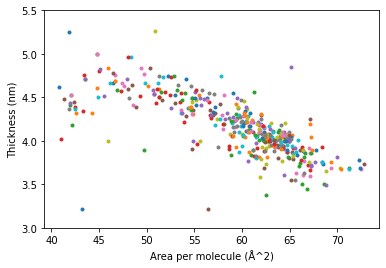

In [2]:
APL = []
Thickness = []
for system in systems:
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if APLvalue and ThicknessValue:
        plt.plot(APLvalue,ThicknessValue,'.')
    plt.xlabel('Area per molecule (Å^2)')
    plt.ylabel('Thickness (nm)')
    plt.ylim([3.0, 5.5])

# Plot correlation between membrane thickness and temperature


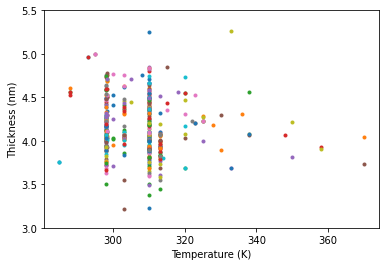

In [3]:
Temperature = []
Thickness = []
for system in systems:
    TEMPERATUREvalue = system['TEMPERATURE']
    ThicknessValue = GetThickness(system)
    if TEMPERATUREvalue and ThicknessValue:
        plt.plot(TEMPERATUREvalue,ThicknessValue,'.')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Thickness (nm)')
    plt.ylim([3.0, 5.5])

# Correlation between area per lipid and the first three minima of form factors


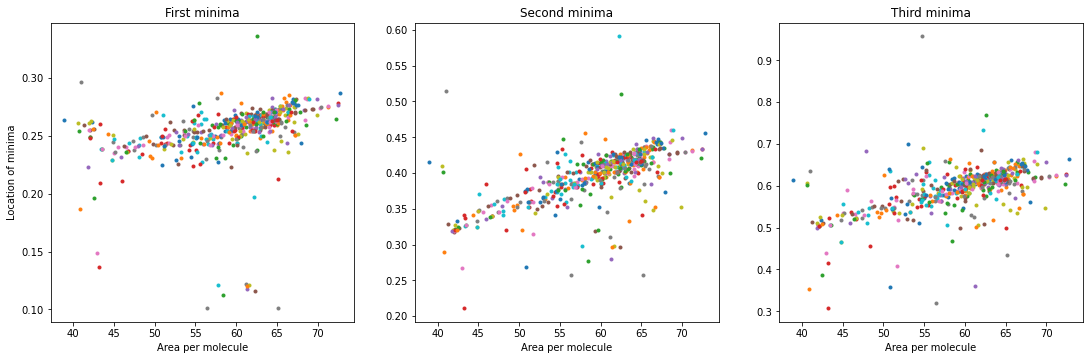

In [4]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("First minima")
ax2.set_title("Second minima")
ax3.set_title("Third minima")
ax1.set_ylabel("Location of minima")
ax1.set_xlabel("Area per molecule")
ax2.set_xlabel("Area per molecule")
ax3.set_xlabel("Area per molecule")

#ax1.set_ylim([0, 1])
#ax2.set_ylim([0, 1])
#ax3.set_ylim([0, 1])

for system in systems:
    #if system['TEMPERATURE'] != 310:
    #    continue
    try:
        FFmins = GetFormFactorMin(system)
    except:
        pass
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    try:
        ax1.plot(APLvalue,FFmins[0],'.')
        ax2.plot(APLvalue,FFmins[1],'.')
        ax3.plot(APLvalue,FFmins[2],'.')
    except:
        pass
    #plt.plot(APLvalue,FFmins[i],'.')


# Correlation between thickness and the first three minima of form factors


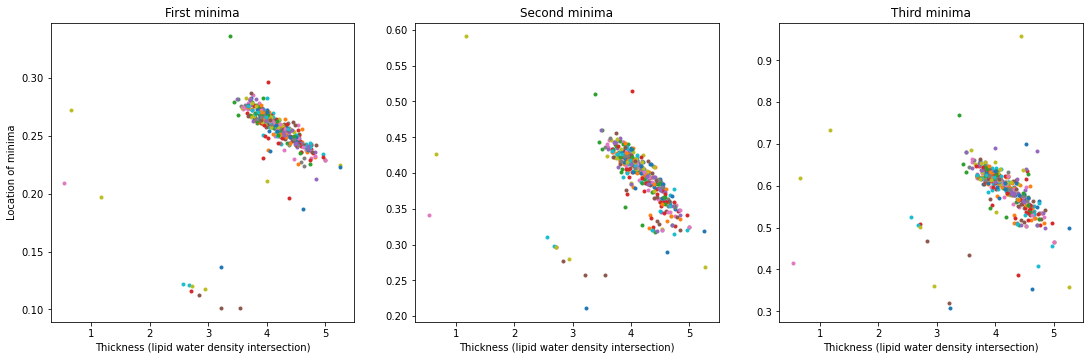

In [5]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("First minima")
ax2.set_title("Second minima")
ax3.set_title("Third minima")
ax1.set_ylabel("Location of minima")
ax1.set_xlabel("Thickness (lipid water density intersection)")
ax2.set_xlabel("Thickness (lipid water density intersection)")
ax3.set_xlabel("Thickness (lipid water density intersection)")


#ax1.set_ylim([0, 1])
#ax2.set_ylim([0, 1])
#ax3.set_ylim([0, 1])

for system in systems:
    #print(system['path'])
    try:
        FFmins = GetFormFactorMin(system)
    except:
        pass
        #print('Failed')
    #APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if ThicknessValue:
        ax1.plot(ThicknessValue,FFmins[0],'.')
        ax2.plot(ThicknessValue,FFmins[1],'.')
        ax3.plot(ThicknessValue,FFmins[2],'.')
        #plt.plot(ThicknessValue,FFmins[0],'.')

# Create correlation matrix for memrane area per lipid, thickness, form factor minima and order

In [ ]:
ID = 0
CorrelationMatrix = {}

for system in systems:
    try:
        FFmins = GetFormFactorMin(system)
    except:
        FFmins = [0,0,0]
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    area = calcArea(system)
    #print(FFmins,APLvalue,ThicknessValue)
    
    tailOPavg = averageOrderParameters(system)
    
    if FFmins[1] == 0 or ThicknessValue == 0 or ThicknessValue < 3:
        continue
    
    ID += 1
    CorrelationMatrix[ID] = {
        'APL': APLvalue, 
        'thickness': ThicknessValue,
        #'FFmin1': FFmins[0],
        'FFmin2' : FFmins[1],
        #'FFmin3' : FFmins[2],
        'sn1op' : tailOPavg[0],
        #'sn2op' : tailOPavg[1],
        #'area' : area
    }

In [ ]:
data = {}
for prop in CorrelationMatrix[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in CorrelationMatrix:
    for prop in CorrelationMatrix[ID]:
        if prop == 'path':
            continue
        data[prop].append(CorrelationMatrix[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)

#corrMatrix = df.corr()
##print (corrMatrix)
#plt.figure(figsize = (20,10))
#sn.heatmap(corrMatrix, annot=True)

#plt.show()

In [ ]:
#df = sn.load_dataset(data,columns=columns)
#sn.PairGrid(df, palette=['red'])



def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10})
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
#g.figure.savefig("correlations.pdf")
g.savefig("correlations.pdf")

# Create area per lipid data of mixtures containing MATRIX or ADDITIVE lipids, or both

In [ ]:
## You can change these to define the MATRIX and ADDITIVE lipids
MATRIX = 'POPC'
ADDITIVE = 'CHOL'



ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
ResultDirThickness = './resultsThickness/' + ADDITIVE + '_in_' + MATRIX + '/'
ResultDirWaterPermeation = './resultsWaterPermeation/' + ADDITIVE + '_in_' + MATRIX + '/'
!mkdir {ResultDir}
!rm {ResultDir}/*
!mkdir {ResultDirThickness}
!rm {ResultDirThickness}/*
!mkdir {ResultDirWaterPermeation}
!rm {ResultDirWaterPermeation}/*



apl_DICT = {}
for system in systems:
    
    try:
        NADDITIVE = np.sum(system['COMPOSITION'][ADDITIVE]['COUNT'])
    except:
        NADDITIVE = 0    
    
    try:
        NMATRIX = np.sum(system['COMPOSITION'][MATRIX]['COUNT'])
    except:
        NMATRIX = 0
    
    NLIPIDS = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NLIPIDS += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    if (NMATRIX + NADDITIVE) != NLIPIDS:
        #print('skipped')
        continue
    
    if system['COMPOSITION']['SOL']['COUNT'] < 20*NLIPIDS:
        #print('skipped')
        continue
    
    if system['DOI'] == '10.5281/zenodo.1293813':
        continue
    
    #print(system['TEMPERATURE'])
    #if system['TEMPERATURE'] > 310 or system['TEMPERATURE'] < 310:
    #    continue
    
    
    APL = CalcAreaPerMolecule(system)
    Thickness = GetThickness(system)
    waterPermeation = getWaterPermeation(system)
    
    
    try:
        CaConcentration = system['COMPOSITION']['CAL']['COUNT'] * 55.5 / system['COMPOSITION']['SOL']['COUNT']
    except:
        CaConcentration = 0
    
    lipidsRATIO = 100*NADDITIVE / NLIPIDS
    forcefield = system.get('FF')
    temperature = round(system.get('TEMPERATURE'))
    DOI = system.get('DOI')
    apl_DICT[lipidsRATIO,CaConcentration,forcefield,temperature,DOI] = APL
    #apl_DICT[lipidsRATIO,CaConcentration,forcefield,DOI] = APL
   
    OutFileName = ResultDir + 'T' + str(temperature) + 'K'
    OutFileNameThickness = ResultDirThickness + 'T' + str(temperature) + 'K'
    OutFileNameWaterPermeation = ResultDirWaterPermeation + 'T' + str(temperature) + 'K'
    
    try:
        NSOD = np.sum(system['COMPOSITION']['SOD']['COUNT'])
    except:
        NSOD = 0    
        
    try:
        NCLA = np.sum(system['COMPOSITION']['CLA']['COUNT'])
    except:
        NCLA = 0    
    
    if NCLA > 0 and not 'DHMDMAB' in ADDITIVE:
        #print('skipped')
        continue
        
    if ('POPG' in ADDITIVE or 'POPS' in ADDITIVE) and NADDITIVE != NSOD:
        #print('skipped')
        continue
    
    try:
        FFname = system['FF'].replace(" ","_")
        FFname = FFname.replace("/","_")
        OutFileName = OutFileName + '_' + FFname +'.dat'
        OutFileNameThickness = OutFileNameThickness + '_' + FFname +'.dat'
        OutFileNameWaterPermeation = OutFileNameWaterPermeation + '_' + FFname +'.dat'
    except:
        continue
    #print(FFname)

    if APL:
        outfile=open(OutFileName,'a')
        outfile.write(str(round(lipidsRATIO,3)) + " " + str(APL) + " " + str(system['DOI']))
        outfile.write('\n')
        outfile.close()
        !sort -n -k 1 {OutFileName} -o {OutFileName}

    if Thickness:
        outfile=open(OutFileNameThickness,'a')
        outfile.write(str(round(lipidsRATIO,3)) + " " + str(Thickness) + " " + str(system['DOI']))
        outfile.write('\n')
        outfile.close()
        !sort -n -k 1 {OutFileNameThickness} -o {OutFileNameThickness}
    if waterPermeation:
        outfile=open(OutFileNameWaterPermeation,'a')
        outfile.write(str(round(lipidsRATIO,3)) + " " + str(waterPermeation) + " " + str(system['DOI']))
        outfile.write('\n')
        outfile.close()
        !sort -n -k 1 {OutFileNameWaterPermeation} -o {OutFileNameWaterPermeation}
        
plotAPLS(MATRIX,ADDITIVE)